In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plot_automations as plotter
import utils

In [2]:
artworks_df = pd.read_csv('../00_preprocessing/omniart-post-color-clustering.csv')

In [3]:
artworks_df

,artwork_name,artist_full_name,creation_year,decade,century,school,palette_count,colors_hex
0,70 amx,xynphix,2007.0,2000,21.0,modern,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...","['#e2ede4', '#969b91', '#6eccb0', '#2c4945', '..."
1,crucifixion (detail),andrea da firenze,1366.0,1360,14.0,Italy,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...","['#947b67', '#7a6351', '#82543d', '#625449', '..."
2,faith,giuseppe angeli,1754.0,1750,18.0,Italy,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...","['#000707', '#9d774c', '#965a36', '#180f0a', '..."
3,lamp post,williamsnape,2010.0,2010,21.0,modern,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...","['#c5aca3', '#967365', '#4c3830', '#402927', '..."
4,the one that got away,katiehofgard,2009.0,2000,21.0,modern,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...","['#fefefe', '#fefefe', '#edf6f3', '#987658', '..."
...,...,...,...,...,...,...,...,...
264213,truth,circlekeeper,2008.0,2000,21.0,modern,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...","['#9f6b61', '#908d71', '#3e2e32', '#191719', '..."
264214,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,2010,21.0,modern,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...","['#fefefe', '#f5f9f9', '#dfe1d4', '#c3b49d', '..."
264215,unknown,kano furunobu,1700.0,1700,18.0,Japan,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...","['#afa691', '#a8906e', '#a8906e', '#9d8f72', '..."
264216,unknown,wang yuanqi,1715.0,1710,18.0,China,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...","['#f5f0e9', '#f7f2ee', '#efe1cf', '#f2d9bc', '..."


In [4]:
colors_df = pd.read_csv('../00_preprocessing/color-centroids.csv')

In [5]:
# Create a lookup dictionary for color properties from the colors dataframe
# This will make it fast to retrieve HSB values for a given HEX code.
color_lookup = colors_df.set_index('HEX').to_dict('index')

**1. Features**

In [6]:
def create_artwork_vector(row, color_map):
    palette_vector = []
    hex_list = row["colors_hex"]
    count_list = row["palette_count"]
    if isinstance(hex_list, str): hex_list = ast.literal_eval(hex_list)
    if isinstance(count_list, str): count_list = ast.literal_eval(count_list)
    for hex_code, count in zip(hex_list, count_list):
        color_info = color_map[hex_code]
        palette_vector.extend([color_info['H_sin'], color_info['H_cos'], color_info['S'], color_info['B'], count])
    return np.array(palette_vector)    

In [7]:
feature_vectors = artworks_df.apply(lambda row: create_artwork_vector(row, color_lookup), axis=1)

In [8]:
X = np.array(feature_vectors.tolist())

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**2. Clustering with K-Means**

In [10]:
unique_decades = artworks_df["decade"].nunique()
unique_schools = artworks_df["school"].nunique()
print(unique_decades, unique_schools)

134 49


In [11]:
K = 100 # 1000 (total colors) / 10 (colors per artwork)

In [12]:
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)

In [13]:
artworks_df['cluster'] = kmeans.fit_predict(X_scaled)

In [14]:
artworks_df

,artwork_name,artist_full_name,creation_year,decade,century,school,palette_count,colors_hex,cluster
0,70 amx,xynphix,2007.0,2000,21.0,modern,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...","['#e2ede4', '#969b91', '#6eccb0', '#2c4945', '...",36
1,crucifixion (detail),andrea da firenze,1366.0,1360,14.0,Italy,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...","['#947b67', '#7a6351', '#82543d', '#625449', '...",81
2,faith,giuseppe angeli,1754.0,1750,18.0,Italy,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...","['#000707', '#9d774c', '#965a36', '#180f0a', '...",33
3,lamp post,williamsnape,2010.0,2010,21.0,modern,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...","['#c5aca3', '#967365', '#4c3830', '#402927', '...",24
4,the one that got away,katiehofgard,2009.0,2000,21.0,modern,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...","['#fefefe', '#fefefe', '#edf6f3', '#987658', '...",76
...,...,...,...,...,...,...,...,...,...
264213,truth,circlekeeper,2008.0,2000,21.0,modern,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...","['#9f6b61', '#908d71', '#3e2e32', '#191719', '...",42
264214,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,2010,21.0,modern,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...","['#fefefe', '#f5f9f9', '#dfe1d4', '#c3b49d', '...",98
264215,unknown,kano furunobu,1700.0,1700,18.0,Japan,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...","['#afa691', '#a8906e', '#a8906e', '#9d8f72', '...",48
264216,unknown,wang yuanqi,1715.0,1710,18.0,China,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...","['#f5f0e9', '#f7f2ee', '#efe1cf', '#f2d9bc', '...",66


In [15]:
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_unscaled = scaler.inverse_transform(cluster_centers_scaled)

In [16]:
export_column_names = []
for n in range(1, 10 + 1):
    export_column_names.extend([f"{n}_H_sin", f"{n}_H_cos", f"{n}_S", f"{n}_B", f"{n}_weight"])

In [17]:
centroids_df = pd.DataFrame(cluster_centers_unscaled, columns=export_column_names)

In [18]:
centroids_df.insert(0, 'name', [f"cluster_{i}" for i in range(K)])

In [19]:
centroids_df

,name,1_H_sin,1_H_cos,1_S,1_B,1_weight,2_H_sin,2_H_cos,2_S,2_B,...,9_H_sin,9_H_cos,9_S,9_B,9_weight,10_H_sin,10_H_cos,10_S,10_B,10_weight
0,cluster_0,0.791800,0.133922,0.074961,0.899168,5030.074250,0.800998,0.141190,0.104510,0.839724,...,0.777080,0.099174,0.136409,0.749289,5312.406500,0.735421,0.047229,0.156489,0.689686,5385.966500
1,cluster_1,0.530026,0.782022,0.216750,0.773710,4793.158448,0.465574,0.804967,0.298091,0.625358,...,0.444518,0.815419,0.321504,0.551500,5200.348628,0.390817,0.804262,0.334045,0.423659,5366.864494
2,cluster_2,-0.166436,-0.552587,0.398104,0.757586,4817.653798,-0.312386,-0.678173,0.533404,0.648958,...,-0.373920,-0.736625,0.646117,0.584332,5098.820050,-0.407253,-0.748510,0.702623,0.549182,5269.719178
3,cluster_3,-0.100049,-0.694466,0.079017,0.826992,4684.306992,-0.240396,-0.823685,0.106344,0.738455,...,0.403223,0.457635,0.268262,0.484555,5223.102969,0.363924,0.413084,0.289920,0.430774,5353.674808
4,cluster_4,0.595687,0.739389,0.377727,0.861292,4295.849112,0.533391,0.790285,0.521619,0.764341,...,0.368858,0.818159,0.623441,0.415258,5758.216568,0.394392,0.813161,0.621872,0.459067,5304.243491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,cluster_95,0.428485,0.701518,0.105666,0.896500,5339.813055,0.308248,0.611336,0.148969,0.822445,...,0.181794,0.628237,0.184095,0.758793,5132.721137,-0.104048,0.457198,0.218095,0.642370,5227.182948
96,cluster_96,0.420525,0.502657,0.145562,0.809123,5201.455257,-0.004806,0.056007,0.220286,0.644355,...,-0.328049,-0.234671,0.260927,0.523656,5285.874328,-0.452689,-0.403373,0.330880,0.431495,5444.749144
97,cluster_97,0.104249,0.881920,0.040403,0.943068,5596.212470,0.117005,0.898931,0.060773,0.905503,...,0.075642,0.879162,0.090622,0.845089,5276.281775,0.040706,0.839970,0.101923,0.790031,5321.805036
98,cluster_98,0.066818,0.896799,0.012185,0.989258,10643.981775,0.041026,-0.714258,0.026356,0.962976,...,0.371582,0.481119,0.153822,0.838213,5474.464748,0.376930,0.426027,0.192283,0.774149,5789.429736


In [20]:
centroids_df.to_csv('artwork-centroids.csv', index=False)

In [35]:
artworks_df.drop(['palette_count', 'colors_hex'], axis=1, inplace=True)

In [36]:
artworks_df.to_csv('omniart-post-artwork-clustering.csv', index=False)

In [33]:
artworks_df['cluster'].value_counts().median()

2457.0

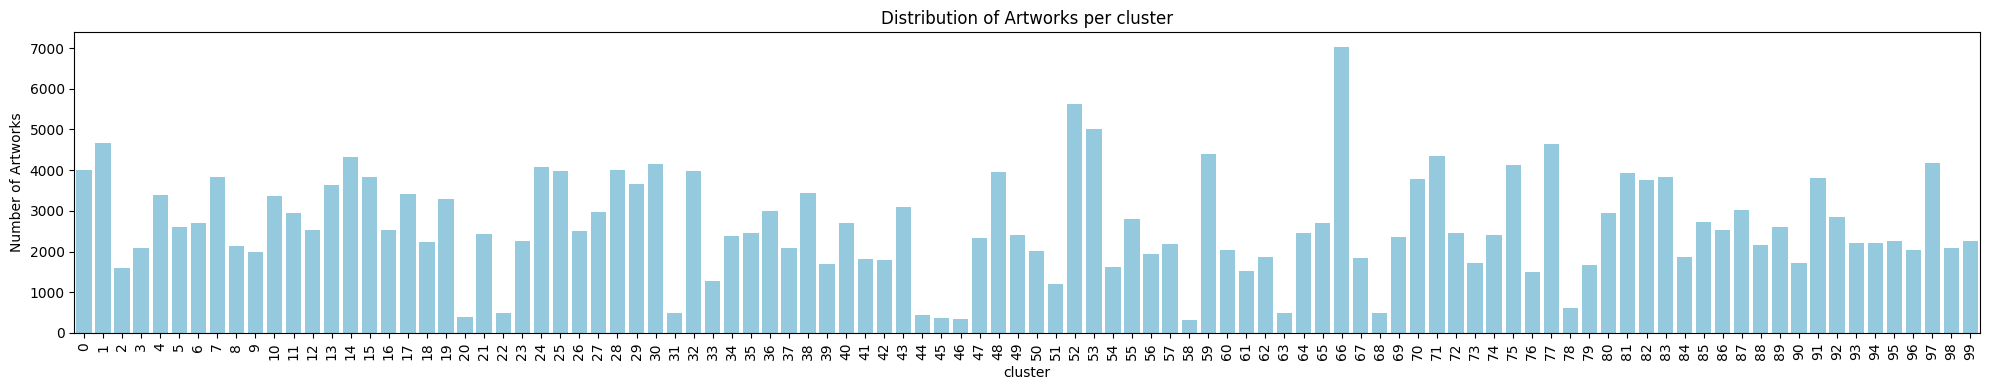

In [21]:
plotter.plot_artwork_distribution(artworks_df, "cluster")

/Users/mulan/Documents/Documents - Giulia’s MacBook Air/UFMG/MINERACAO/project/art_data_mining/plot_automations.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


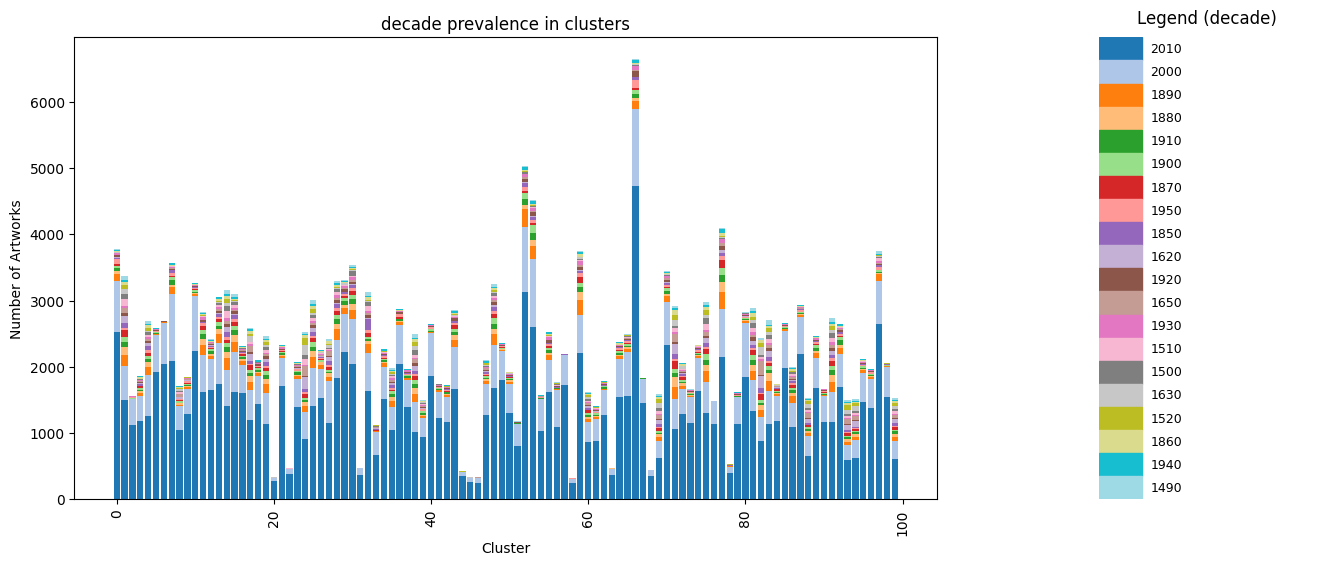

In [22]:
plotter.plot_cluster_vs_dim(artworks_df, "decade")

/Users/mulan/Documents/Documents - Giulia’s MacBook Air/UFMG/MINERACAO/project/art_data_mining/plot_automations.py:217: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


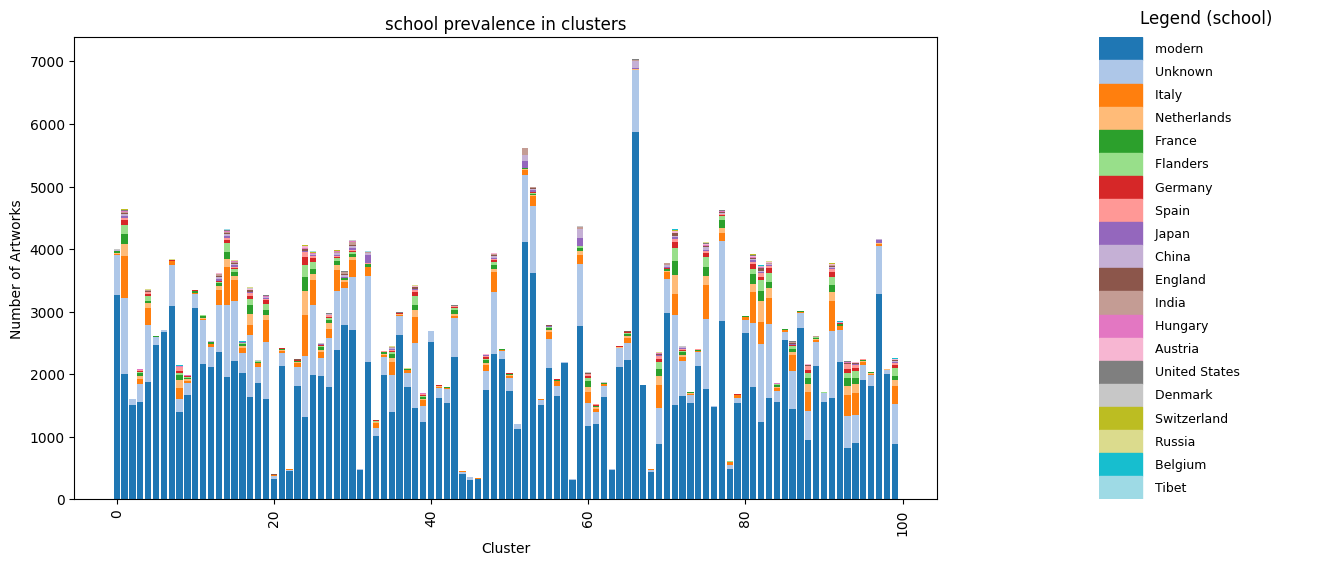

In [23]:
plotter.plot_cluster_vs_dim(artworks_df, "school")

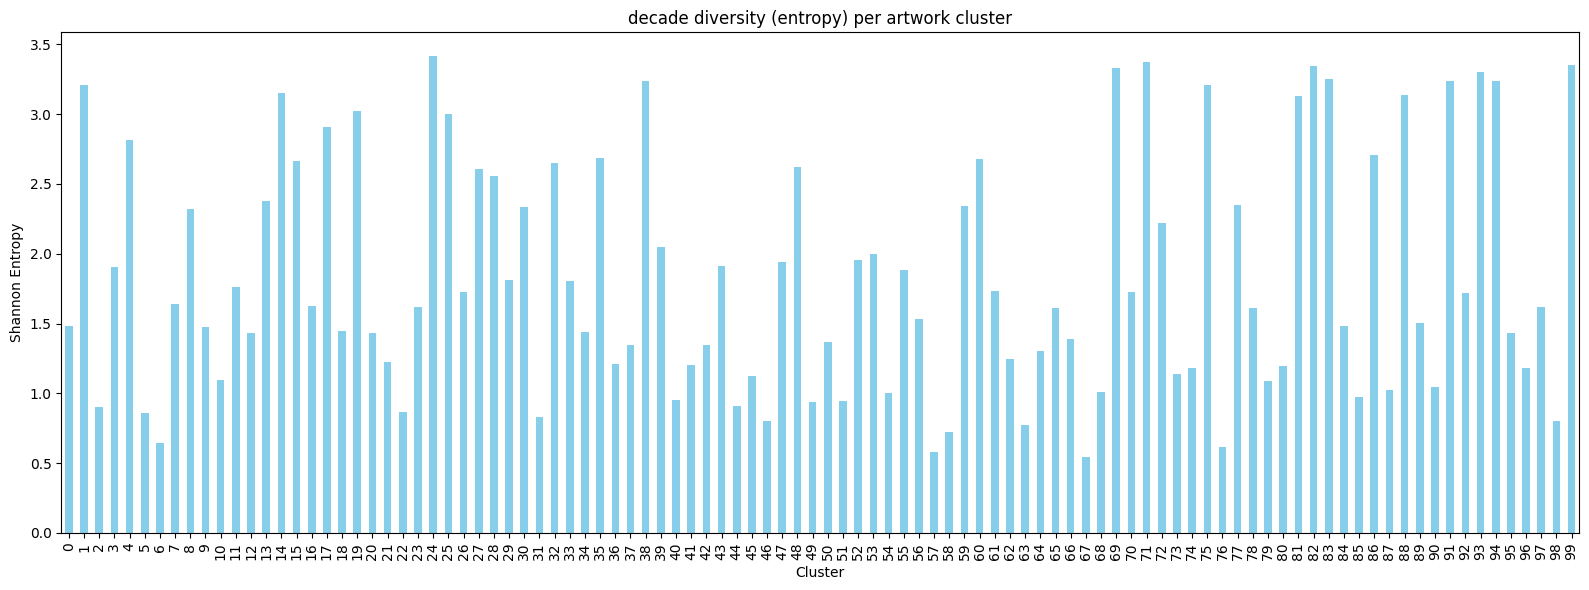

In [24]:
plotter.plot_entropy(artworks_df, "decade")

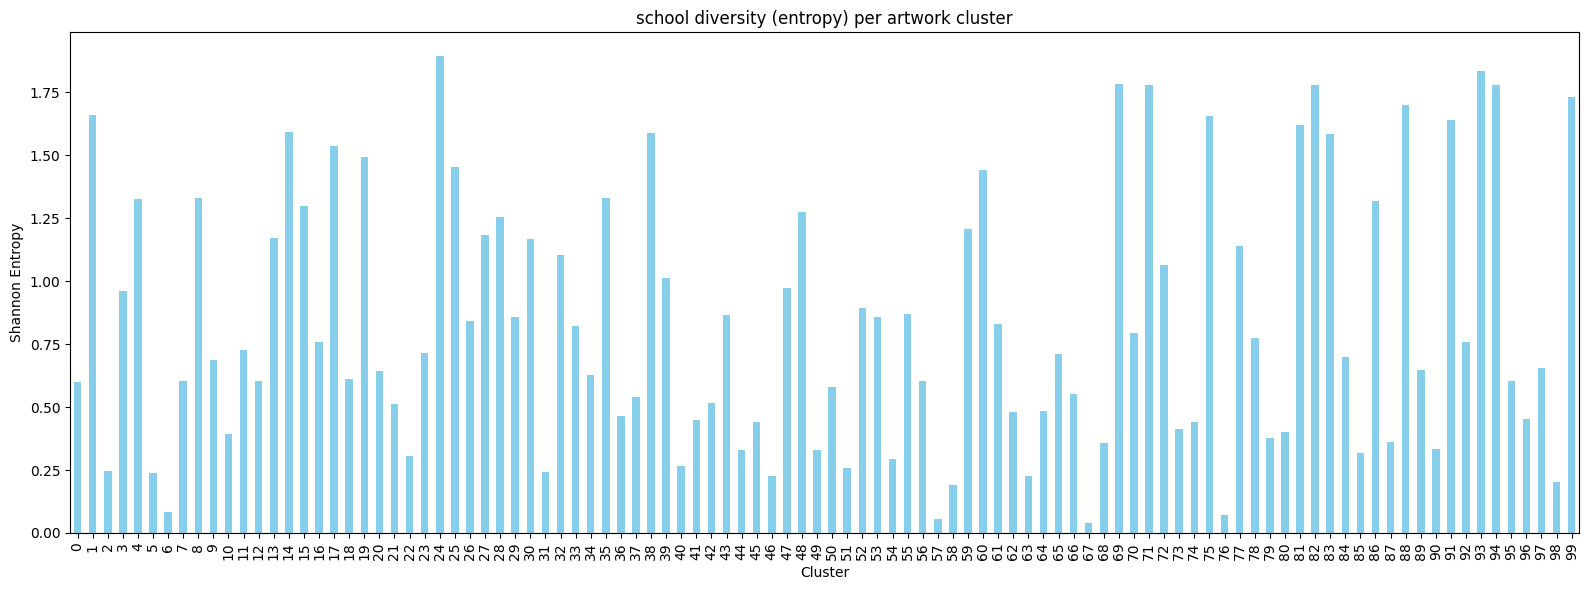

In [25]:
plotter.plot_entropy(artworks_df, "school")

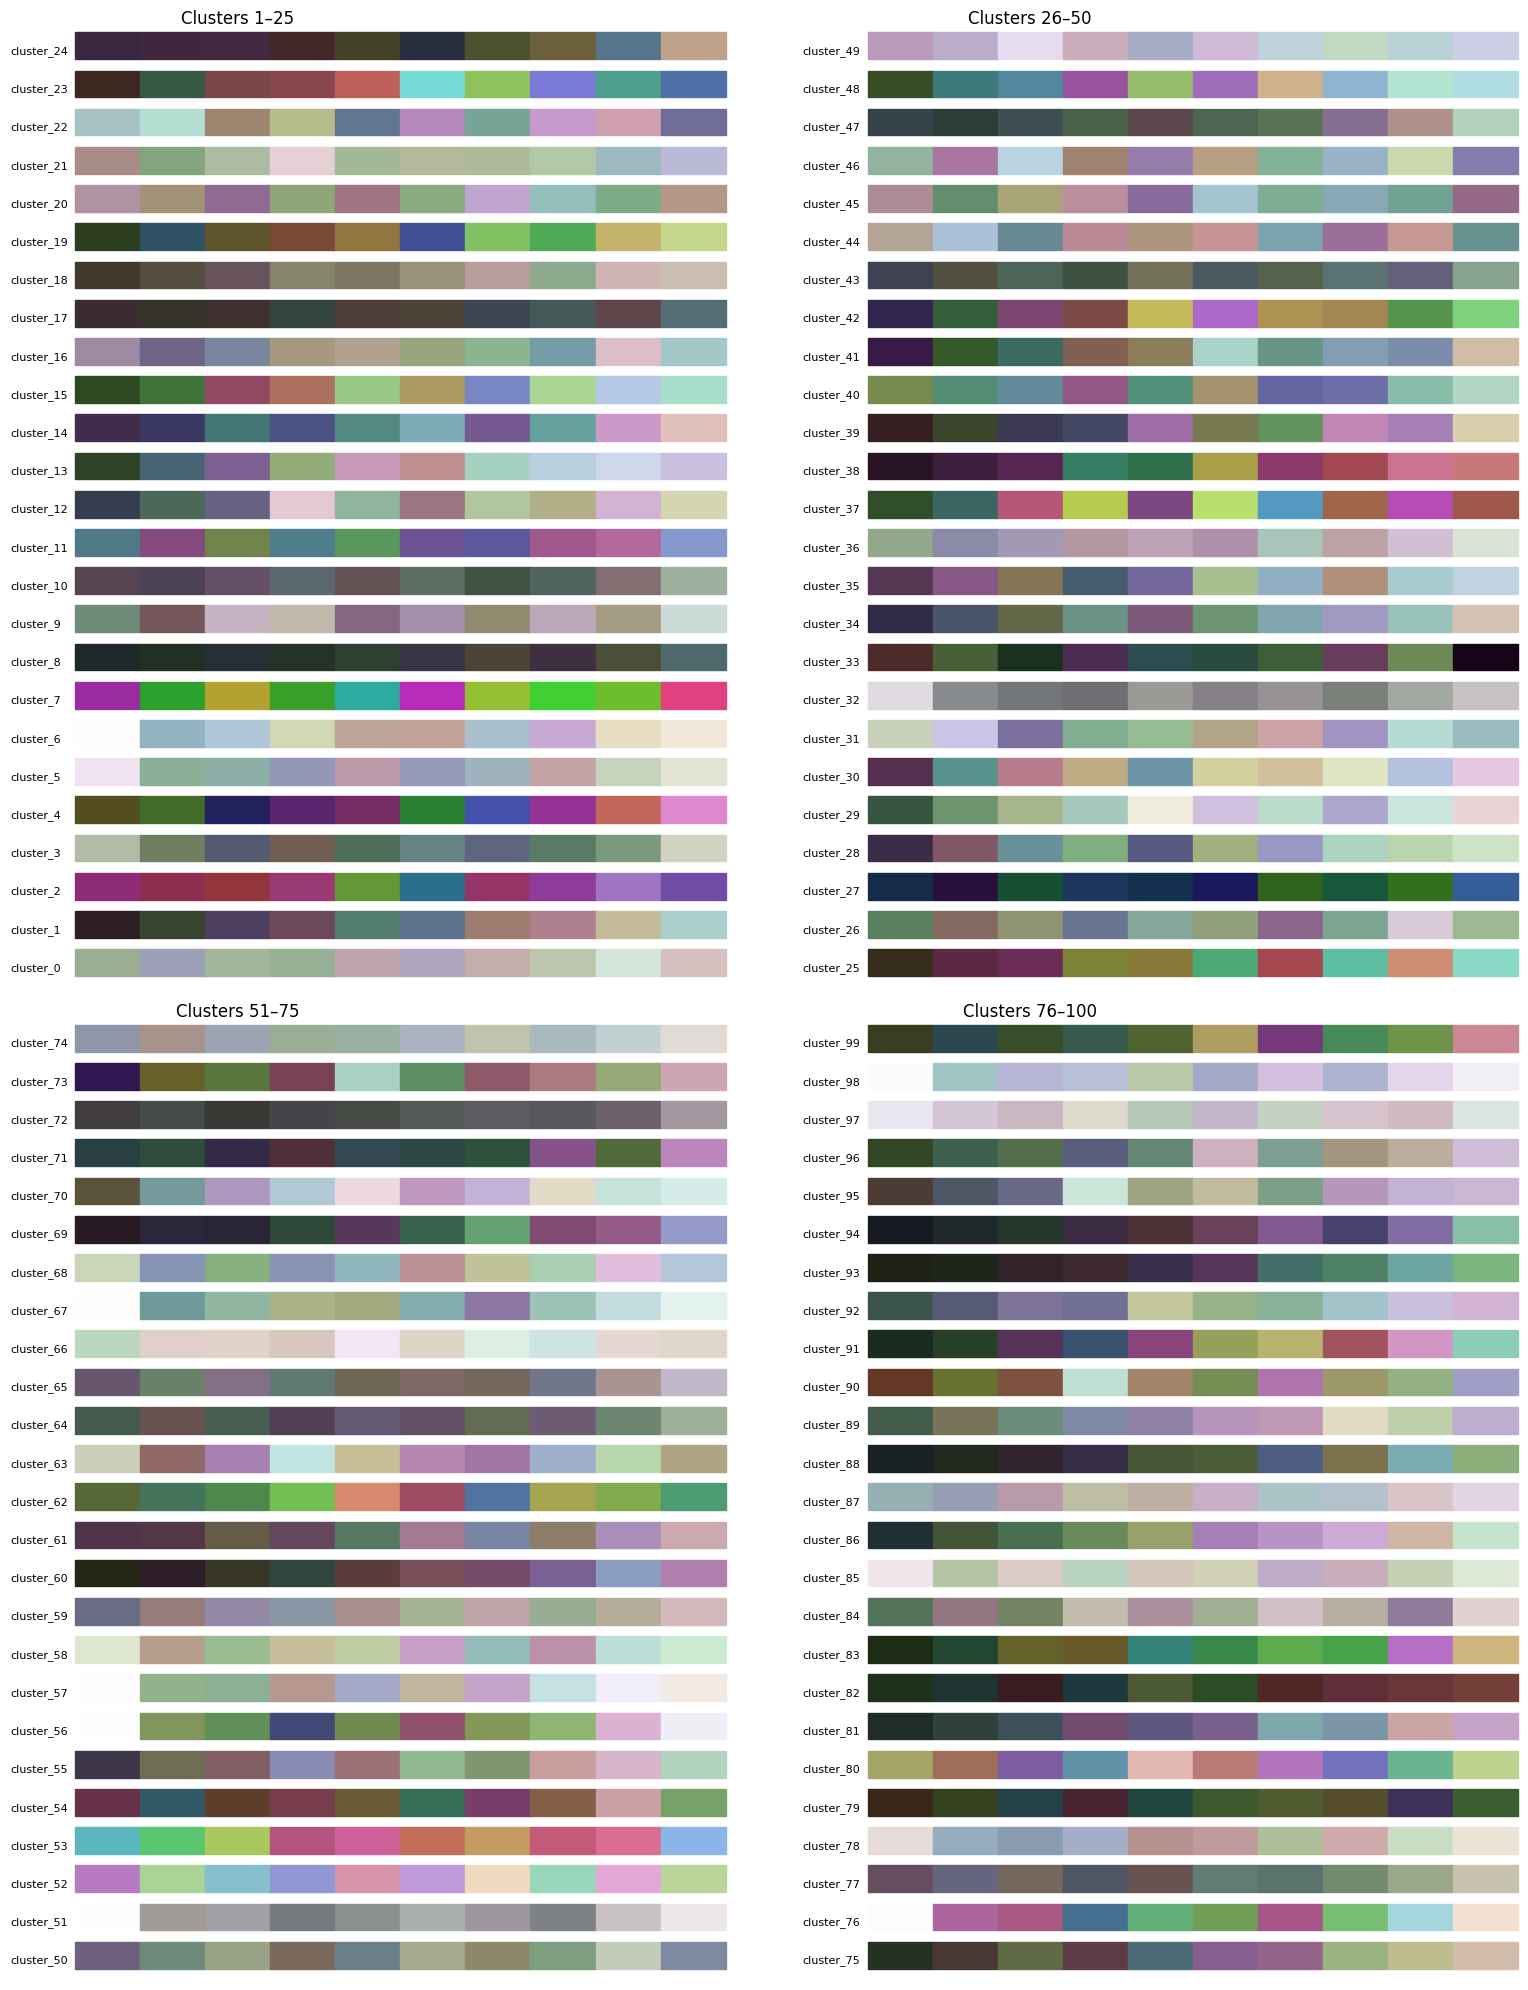

In [31]:
plotter.plot_artworks_clusters_centroids(centroids_df)